# Simulation in Drake

## First, from pydrake.all import necessary packages. 

In [1]:
import matplotlib.pyplot as plt
from pydrake.all import (BasicVector, LeafSystem, DiagramBuilder, Simulator, LogOutput, ConstantVectorSource, 
                         LinearSystem)
import numpy as np
import scipy.linalg as la

## Now, let's define and test a discrete time system

In [ ]:
# Define the system.
class Yuntian(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)
        num_DTState = 1
        num_input = 1
        num_output = 2
        # Define the state vector
        self.DeclareDiscreteState(num_DTState)
        # Define the input
        self.DeclareVectorInputPort("u", BasicVector(num_input))
        # Define the output
        self.DeclareVectorOutputPort("y", BasicVector(num_output), self.CalcOutputY)
        self.DeclarePeriodicDiscreteUpdate(0.01)  # One second timestep.         
       
    def DoCalcDiscreteVariableUpdates(self, context, events, discrete_state):
        x = context.get_discrete_state_vector().CopyToVector()
        u = self.get_input_port(0).Eval(context)
        xnext = 0.98*x + 5*u
        discrete_state.get_mutable_vector().SetFromVector(xnext)
        
    def CalcOutputY(self, context, output):
        x = context.get_discrete_state_vector().CopyToVector()
        u = self.get_input_port(0).Eval(context)
        y = np.array([x,u])
        output.SetFromVector(y)

In [ ]:
# testing 

# Create a simple block diagram containing our system.
builder = DiagramBuilder()
mySys_Yuntian = builder.AddSystem(Yuntian())
stepInput = builder.AddSystem(ConstantVectorSource([1]))  #step-input

builder.Connect(stepInput.get_output_port(0), mySys_Yuntian.get_input_port(0))  #connect input to mysystem
logger_output = LogOutput(mySys_Yuntian.get_output_port(0), builder)
logger_input = LogOutput(stepInput.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x1(0), x2(0), x3(0)
context = diagram.CreateDefaultContext()
context.SetDiscreteState([0.5])

# Create the simulator
simulator = Simulator(diagram, context)
simulator.AdvanceTo(5)

# Plot the results.
plt.figure()
plt.plot(logger_output.sample_times(), logger_output.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')

## Example of continuous time system

In [ ]:
# Define the system.
class CTYuntian(LeafSystem):
    def __init__(self, A, B, C):
        LeafSystem.__init__(self)
        
        num_state = A.shape[0]
        num_input = B.shape[1]
        num_output = C.shape[0]
        
        # Define the state vector
        self.DeclareContinuousState(num_state)  
        # Define the input
        self.DeclareVectorInputPort("u", BasicVector(num_input))
        # Define the output
        self.DeclareVectorOutputPort("y", BasicVector(num_output), self.CalcOutputY, set([self.all_state_ticket()])) 
        
        self._A = A
        self._B = B
        self._C = C
        
    def DoCalcTimeDerivatives(self, context, derivatives):
        # Get the state vector
        x = context.get_continuous_state_vector().CopyToVector()
        # Get the input
        u = self.get_input_port(0).Eval(context)
    
        xdot = self._A @ x + self._B @ u
#       derivatives.get_mutable_vector().SetFromVector(xdot)
        derivatives.get_mutable_vector().SetFromVector(xdot)
        
    # y = Cx 
    def CalcOutputY(self, context, output):
        x = context.get_continuous_state_vector().CopyToVector()
        y = self._C @ x
        output.SetFromVector(y)

In [ ]:
# testing 
A = np.array([[0, 1, 0], [0, 0, 1],[-6, -11, -6]])    
B = np.array([1, 1, 1]).reshape(3,1)
C = np.identity(3)
D = np.zeros((3,1))

# Create a simple block diagram containing our system.
builder = DiagramBuilder()
mySys = builder.AddSystem(CTYuntian(A, B, C))
stepInput = builder.AddSystem(ConstantVectorSource([0]))  #step-input
builder.Connect(stepInput.get_output_port(0), mySys.get_input_port(0))  #connect input to my system
logger_output = LogOutput(mySys.get_output_port(0), builder)
logger_input = LogOutput(stepInput.get_output_port(0), builder)
diagram = builder.Build()


# Set the initial conditions, x1(0), x2(0), x3(0)
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.5, 0.5, 0.5])

# Create the simulator
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
plt.figure()
plt.plot(logger_output.sample_times(), logger_output.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')

## Complete Design of Output Feedback control

### Simulate open-loop response of the given plant


Text(0, 0.5, 'y(t)')

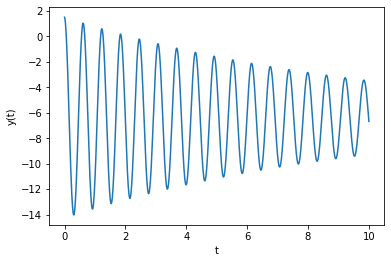

In [3]:
# system dynamics given in continuous time
A =np.mat('33, -60; 20, -33.2')
B =np.mat('1; 1')
C =np.mat('2,1')
D =np.mat('0')

# Create a simple block diagram containing our system.
builder = DiagramBuilder()
CT_sys = builder.AddSystem(LinearSystem(A,B,C,D))
stepInput = builder.AddSystem(ConstantVectorSource([10]))  #step-input
builder.Connect(stepInput.get_output_port(0), CT_sys.get_input_port(0))  #connect input to my system
logger_output = LogOutput(CT_sys.get_output_port(0), builder)
#logger_input = LogOutput(stepInput.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x1(0), x2(0), x3(0)
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.5, 0.5])

# Create the simulator
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
plt.figure()
plt.plot(logger_output.sample_times(), logger_output.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')


### Now let's design of controller  + observer

In [9]:

# convert it to discrete time 
T = 0.01
Ad = np.eye(2) + A*T
Bd = B*T
Cd = C

s_desired = np.array([-4+2*1j, -4-2*1j])
z_desired = np.exp(s_desired*T)

import scipy.signal as sig
K = sig.place_poles(Ad,Bd,z_desired).gain_matrix

obs_eig_s = np.array([-16+1j, -16-1j])
obs_eig_z = np.exp(obs_eig_s*T)
Ktilde = sig.place_poles(Ad.T,Cd.T,obs_eig_z)
L = Ktilde.gain_matrix.T

# print(obs_eig_z)
# print(la.eig(Ad-L*Cd))

In [5]:
print(obs_eig_z)
print(la.eig(Ad-L*Cd))

[0.92307019+0.00923101j 0.92307019-0.00923101j]
(array([0.92307019+0.00923101j, 0.92307019-0.00923101j]), array([[0.91461719+0.j        , 0.91461719-0.j        ],
       [0.40411732-0.01282949j, 0.40411732+0.01282949j]]))


In [ ]:
# now construct observer
A_obv = Ad - L*Cd
B_obv = np.hstack([Bd, L])
C_obv = np.identity(2)
D_obv = np.zeros((2,1))

print(la.eig(A_obv))
T

In [6]:
# Define the system.
class DTObserver(LeafSystem):
    def __init__(self,A,B,C,L,T):
        LeafSystem.__init__(self)
        n = A.shape[0]
        m = B.shape[1]
        p = C.shape[0]        
        self.DeclareDiscreteState(n)
        # Define the input
        self.DeclareVectorInputPort("uk", BasicVector(m))
        self.DeclareVectorInputPort("yk", BasicVector(p))
        # Define the output
        self.DeclareVectorOutputPort("x_estimated", BasicVector(n), self.CalcOutputY, set([self.all_state_ticket()]))
        self.DeclarePeriodicDiscreteUpdate(T)  # One second timestep.         
        self.A = A
        self.B = B
        self.C = C
        self.L = L
    def DoCalcDiscreteVariableUpdates(self, context, events, discrete_state):
        xk = context.get_discrete_state_vector().CopyToVector()
        uk = self.get_input_port(0).Eval(context)
        yk = self.get_input_port(1).Eval(context)
        A = self.A 
        B = self.B 
        C = self.C
        L = self.L
        xk = np.mat(xk.reshape((2,1)))        
        xnext = A*xk + B*uk + L*(yk - C*xk)        
        discrete_state.get_mutable_vector().SetFromVector(xnext)
        
    def CalcOutputY(self, context, output):
        x = context.get_discrete_state_vector().CopyToVector()
        y = x
        output.SetFromVector(y)

In [7]:
print(K)

[[3.65855144 0.1115158 ]]


### Simulate the closed-loop response

Text(0, 0.5, 'y(t)')

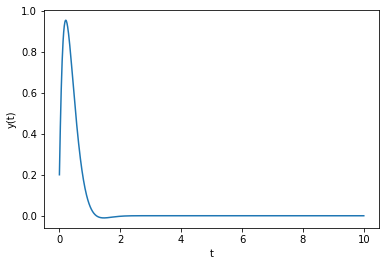

In [12]:
from pydrake.all import MatrixGain
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
#CT_sys = builder.AddSystem(LinearSystem(Ad,Bd,Cd,D,T))
CT_sys=builder.AddSystem(LinearSystem(A,B,C,D))
my_controller = builder.AddSystem(MatrixGain(-K))
my_observer = builder.AddSystem(DTObserver(Ad,Bd,Cd,L,T))

builder.Connect(my_controller.get_output_port(0), CT_sys.get_input_port(0)) 
builder.Connect(my_controller.get_output_port(0), my_observer.get_input_port(0))
builder.Connect(CT_sys.get_output_port(0), my_observer.get_input_port(1))
builder.Connect(my_observer.get_output_port(0), my_controller.get_input_port(0))

logger_output = LogOutput(CT_sys.get_output_port(0), builder)
diagram = builder.Build()

simulator = Simulator(diagram)
context = simulator.get_mutable_context()  #overall context

# now let's get subsystem context
plant_context = diagram.GetMutableSubsystemContext(CT_sys, context)
#plant_context.SetDiscreteState([0.1,0])
plant_context.SetContinuousState([0.1,0])
observer_context = diagram.GetMutableSubsystemContext(my_observer, context)
observer_context.SetDiscreteState([0,0])

simulator.AdvanceTo(10)

# Plot the results.
plt.figure()
plt.plot(logger_output.sample_times(), logger_output.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')